In [1]:
#from IPython.display import display
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import os
#import shutil
#import posixpath
import datetime
import wfdb

import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam


Using TensorFlow backend.
C:\Users\niekh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\niekh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\niekh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\niekh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
record = wfdb.rdrecord('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')
display(record.__dict__)
display(annotation.__dict__)

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

{'record_name': '100',
 'extension': 'atr',
 'sample': array([    18,     77,    370, ..., 649484, 649734, 649991]),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'A',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

In [6]:
# All relevant symbols for this research.
relsym = set("NLRejV!EAaSJF/fQ")

def to_aami(ba):
    if ba in set("NLRej"):
        return "Normal"
    if ba in set("V!E"):
        return "Ventricular"
    if ba in set("AaSJ"):
        return "Supraventricular"
    if ba == "F":
        return "Fusion beat"
    if ba in set("/fQ"):
        return "Unknown beats"
    else: 
        return "This should not be happening."

def to_aami_num(aami):
    d = {"Normal" : 0,
        "Ventricular" : 1,
        "Supraventricular" : 2,
        "Fusion beat" : 3,
        "Unknown beats" : 4}
    return d[aami]

    
class Beat:
    def __init__(self, ba, patient):
        self.ba = ba
        self.aami = to_aami(ba)
        self.aami_num = to_aami_num(self.aami)
        self.patient = patient
        

beats = []
window = int(0.5*360)

# for file in os.listdir("mitdb"):
#     if file.endswith(".atr"):
#         record = wfdb.rdrecord("mitdb/"+file.split(".")[0])
#         ann = wfdb.rdann("mitdb/"+record.record_name, 'atr')
#         for i in range(ann.ann_len - 50):
#             ba = ann.symbol[i]
#             s = ann.sample[i]
#             if ba in relsym and s > window:
#                 beat = Beat(ba, record.record_name)
#                 beat.start = s - window
#                 beat.end = s + window
#                 signal = []
#                 for t in record.p_signal[beat.start:beat.end]:
#                     signal.append(t[0])
#                 beat.signal = signal
#                 beats.append(beat)


for file in os.listdir("mitdb"):
    if file.endswith(".atr"):
        record = wfdb.rdrecord("mitdb/"+file.split(".")[0])
        ann = wfdb.rdann("mitdb/"+record.record_name, 'atr')
        end = 0
        for i in range(ann.ann_len - 1):
            ba = ann.symbol[i]
            if ba in relsym:
                beat = Beat(ba, record.record_name)
                beat.start = end
                end = int((ann.sample[i] + ann.sample[i+1]) / 2)
                beat.end = end
                signal = []
                for t in record.p_signal[beat.start:beat.end]:
                    signal.append(t[0])
                beat.signal = signal
                beats.append(beat)

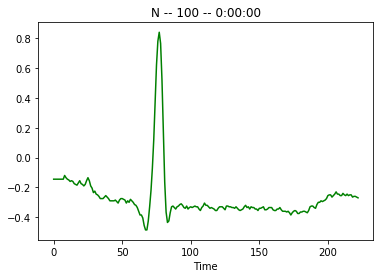

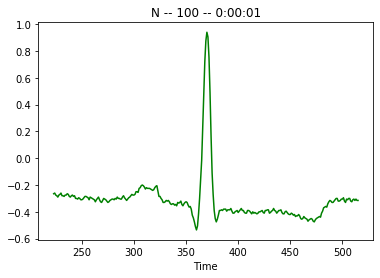

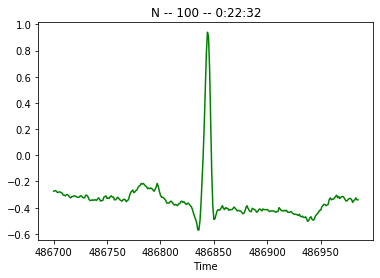

In [7]:
def print_beat(beat):
    fig, ax = plt.subplots()
    plt.title("{} -- {} -- {}".format(beat.ba, beat.patient, datetime.timedelta(seconds=round(beat.start/360))))

    plt.locator_params(axis='y', nbins=10)
    ax.plot(range(beat.start, beat.end), beat.signal, 'g')
    ax.set_xlabel('Time')

print_beat(beats[0])
print_beat(beats[1])
print_beat(beats[1701])

In [5]:
maxlen = 0
avglen = 0
for b in beats:
    l = len(b.signal)
    avglen += l
    if l > maxlen:
        maxlen = l
        #print(" {} - {} - {}".format(b.patient, b.ba, b.start))
print(" avg: {} -- max: {}".format(round(avglen/len(beats)),maxlen))

 avg: 1800 -- max: 1800


In [27]:
model = Sequential([
    Dense(units=1, input_dim=1800, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=5, activation='softmax')
])
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

signals, labels = [], []
for b in beats:
    signals.append(b.signal)
    labels.append(b.aami_num)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 1801      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 325       
Total params: 14,734
Trainable params: 14,734
Non-trainable params: 0
__________________________________________________

In [28]:
model.fit(x=np.asarray(signals), y=np.asarray(labels), validation_split=0.2, epochs=20, shuffle=True, verbose=2)

Train on 82506 samples, validate on 20627 samples
Epoch 1/20
 - 5s - loss: 0.3495 - accuracy: 0.8869 - val_loss: 0.5759 - val_accuracy: 0.8032
Epoch 2/20
 - 4s - loss: 0.3225 - accuracy: 0.8925 - val_loss: 0.5679 - val_accuracy: 0.8492
Epoch 3/20
 - 4s - loss: 0.3169 - accuracy: 0.8985 - val_loss: 0.6257 - val_accuracy: 0.8223
Epoch 4/20
 - 4s - loss: 0.3163 - accuracy: 0.9007 - val_loss: 0.6421 - val_accuracy: 0.8225
Epoch 5/20
 - 4s - loss: 0.3103 - accuracy: 0.9017 - val_loss: 0.6318 - val_accuracy: 0.8097
Epoch 6/20
 - 4s - loss: 0.3108 - accuracy: 0.9063 - val_loss: 0.6534 - val_accuracy: 0.8183
Epoch 7/20
 - 4s - loss: 0.3056 - accuracy: 0.9087 - val_loss: 0.6210 - val_accuracy: 0.8282
Epoch 8/20
 - 4s - loss: 0.3085 - accuracy: 0.9077 - val_loss: 0.6564 - val_accuracy: 0.8202
Epoch 9/20
 - 4s - loss: 0.3147 - accuracy: 0.9006 - val_loss: 0.6919 - val_accuracy: 0.8034
Epoch 10/20
 - 4s - loss: 0.3100 - accuracy: 0.9072 - val_loss: 0.6212 - val_accuracy: 0.8254
Epoch 11/20
 - 4s -